# Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [1]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np
import pandas as pd

import random

import thinkstats2
import thinkplot

## Survival analysis

If we have an unbiased sample of complete lifetimes, we can compute the survival function from the CDF and the hazard function from the survival function.

Here's the distribution of pregnancy length in the NSFG dataset.

In [2]:
import nsfg

preg = nsfg.ReadFemPreg()
complete = preg.query('outcome in [1, 3, 4]').prglngth
cdf = thinkstats2.Cdf(complete, label='cdf')

The survival function is just the complementary CDF.

In [3]:
import survival

def MakeSurvivalFromCdf(cdf, label=''):
    """Makes a survival function based on a CDF.

    cdf: Cdf
    
    returns: SurvivalFunction
    """
    ts = cdf.xs
    ss = 1 - cdf.ps
    return survival.SurvivalFunction(ts, ss, label)

In [4]:
sf = MakeSurvivalFromCdf(cdf, label='survival')

In [5]:
print(cdf[13])
print(sf[13])

0.13978014121
0.86021985879


Here's the CDF and SF.

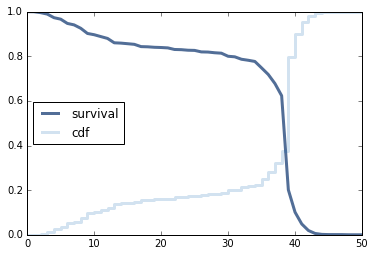

In [6]:
thinkplot.Plot(sf)
thinkplot.Cdf(cdf, alpha=0.2)
thinkplot.Config(loc='center left')

And here's the hazard function.

In [7]:
hf = sf.MakeHazardFunction(label='hazard')
print(hf[39])

0.676706827309


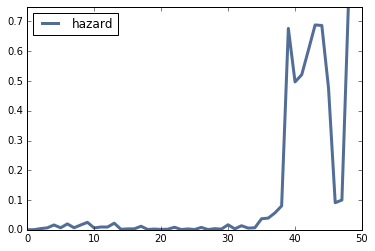

In [8]:
thinkplot.Plot(hf)
thinkplot.Config(ylim=[0, 0.75], loc='upper left')

## Age at first marriage

We'll use the NSFG respondent file to estimate the hazard function and survival function for age at first marriage.

In [9]:
resp6 = nsfg.ReadFemResp()

We have to clean up a few variables.

In [10]:
resp6.cmmarrhx.replace([9997, 9998, 9999], np.nan, inplace=True)
resp6['agemarry'] = (resp6.cmmarrhx - resp6.cmbirth) / 12.0
resp6['age'] = (resp6.cmintvw - resp6.cmbirth) / 12.0

And the extract the age at first marriage for people who are married, and the age at time of interview for people who are not.

In [11]:
complete = resp6[resp6.evrmarry==1].agemarry.dropna()
ongoing = resp6[resp6.evrmarry==0].age

The following function uses Kaplan-Meier to estimate the hazard function.

In [12]:
from collections import Counter

def EstimateHazardFunction(complete, ongoing, label='', verbose=False):
    """Estimates the hazard function by Kaplan-Meier.

    http://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator

    complete: list of complete lifetimes
    ongoing: list of ongoing lifetimes
    label: string
    verbose: whether to display intermediate results
    """
    if np.sum(np.isnan(complete)):
        raise ValueError("complete contains NaNs")
    if np.sum(np.isnan(ongoing)):
        raise ValueError("ongoing contains NaNs")

    hist_complete = Counter(complete)
    hist_ongoing = Counter(ongoing)

    ts = list(hist_complete | hist_ongoing)
    ts.sort()

    at_risk = len(complete) + len(ongoing)

    lams = pd.Series(index=ts)
    for t in ts:
        ended = hist_complete[t]
        censored = hist_ongoing[t]

        lams[t] = ended / at_risk
        if verbose:
            print(t, at_risk, ended, censored, lams[t])
        at_risk -= ended + censored

    return survival.HazardFunction(lams, label=label)

Here is the hazard function and corresponding survival function. 

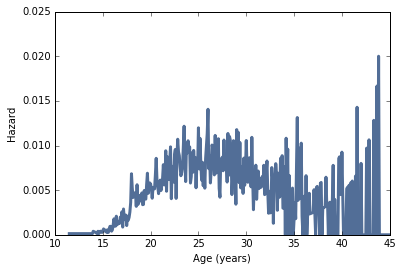

In [13]:
hf = EstimateHazardFunction(complete, ongoing)
thinkplot.Plot(hf)
thinkplot.Config(xlabel='Age (years)',
                 ylabel='Hazard')

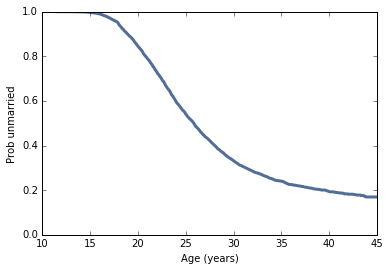

In [14]:
sf = hf.MakeSurvival()
thinkplot.Plot(sf)
thinkplot.Config(xlabel='Age (years)',
                 ylabel='Prob unmarried',
                 ylim=[0, 1])

## Quantifying uncertainty

To see how much the results depend on random sampling, we'll use a resampling process again.

In [15]:
def EstimateMarriageSurvival(resp):
    """Estimates the survival curve.

    resp: DataFrame of respondents

    returns: pair of HazardFunction, SurvivalFunction
    """
    # NOTE: Filling missing values would be better than dropping them.
    complete = resp[resp.evrmarry == 1].agemarry.dropna()
    ongoing = resp[resp.evrmarry == 0].age

    hf = EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

In [16]:
def ResampleSurvival(resp, iters=101):
    """Resamples respondents and estimates the survival function.

    resp: DataFrame of respondents
    iters: number of resamples
    """ 
    _, sf = EstimateMarriageSurvival(resp)
    thinkplot.Plot(sf)

    low, high = resp.agemarry.min(), resp.agemarry.max()
    ts = np.arange(low, high, 1/12.0)

    ss_seq = []
    for _ in range(iters):
        sample = thinkstats2.ResampleRowsWeighted(resp)
        _, sf = EstimateMarriageSurvival(sample)
        ss_seq.append(sf.Probs(ts))

    low, high = thinkstats2.PercentileRows(ss_seq, [5, 95])
    thinkplot.FillBetween(ts, low, high, color='gray', label='90% CI')

The following plot shows the survival function based on the raw data and a 90% CI based on resampling.

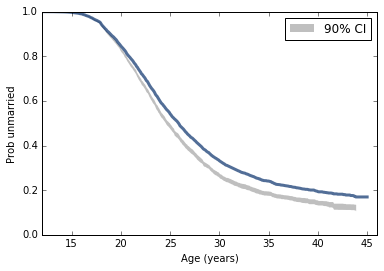

In [17]:
ResampleSurvival(resp6)
thinkplot.Config(xlabel='Age (years)',
                 ylabel='Prob unmarried',
                 xlim=[12, 46],
                 ylim=[0, 1],
                 loc='upper right')

The SF based on the raw data falls outside the 90% CI because the CI is based on weighted resampling, and the raw data is not.  You can confirm that by replacing `ResampleRowsWeighted` with `ResampleRows` in `ResampleSurvival`.

## More data

To generate survivial curves for each birth cohort, we need more data, which we can get by combining data from several NSFG cycles.

In [18]:
resp5 = survival.ReadFemResp1995()
resp6 = survival.ReadFemResp2002()
resp7 = survival.ReadFemResp2010()

In [19]:
resps = [resp5, resp6, resp7]

The following is the code from `survival.py` that generates SFs broken down by decade of birth.

In [20]:
def AddLabelsByDecade(groups, **options):
    """Draws fake points in order to add labels to the legend.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for name, _ in groups:
        label = '%d0s' % name
        thinkplot.Plot([15], [1], label=label, **options)

def EstimateMarriageSurvivalByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for _, group in groups:
        _, sf = EstimateMarriageSurvival(group)
        thinkplot.Plot(sf, **options)

def PlotResampledByDecade(resps, iters=11, predict_flag=False, omit=None):
    """Plots survival curves for resampled data.

    resps: list of DataFrames
    iters: number of resamples to plot
    predict_flag: whether to also plot predictions
    """
    for i in range(iters):
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby('decade')

        if omit:
            groups = [(name, group) for name, group in groups 
                      if name not in omit]

        # TODO: refactor this to collect resampled estimates and
        # plot shaded areas
        if i == 0:
            AddLabelsByDecade(groups, alpha=0.7)

        if predict_flag:
            PlotPredictionsByDecade(groups, alpha=0.1)
            EstimateMarriageSurvivalByDecade(groups, alpha=0.1)
        else:
            EstimateMarriageSurvivalByDecade(groups, alpha=0.2)

Here are the results for the combined data.

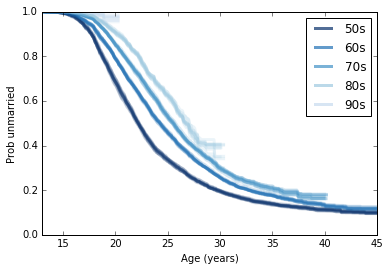

In [21]:
PlotResampledByDecade(resps)
thinkplot.Config(xlabel='Age (years)',
                   ylabel='Prob unmarried',
                   xlim=[13, 45],
                   ylim=[0, 1])

We can generate predictions by assuming that the hazard function of each generation will be the same as for the previous generation.

In [22]:
def PlotPredictionsByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    hfs = []
    for _, group in groups:
        hf, sf = EstimateMarriageSurvival(group)
        hfs.append(hf)

    thinkplot.PrePlot(len(hfs))
    for i, hf in enumerate(hfs):
        if i > 0:
            hf.Extend(hfs[i-1])
        sf = hf.MakeSurvival()
        thinkplot.Plot(sf, **options)

And here's what that looks like.

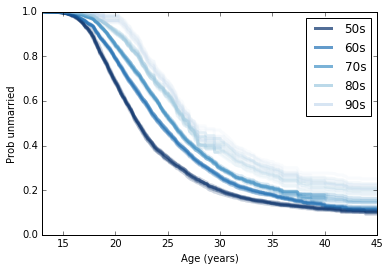

In [23]:
PlotResampledByDecade(resps, predict_flag=True)
thinkplot.Config(xlabel='Age (years)',
                 ylabel='Prob unmarried',
                 xlim=[13, 45],
                 ylim=[0, 1])

## Remaining lifetime

Distributions with difference shapes yield different behavior for remaining lifetime as a function of age.

In [24]:
preg = nsfg.ReadFemPreg()

complete = preg.query('outcome in [1, 3, 4]').prglngth
print('Number of complete pregnancies', len(complete))
ongoing = preg[preg.outcome == 6].prglngth
print('Number of ongoing pregnancies', len(ongoing))

hf = EstimateHazardFunction(complete, ongoing)
sf1 = hf.MakeSurvival()

Number of complete pregnancies 11189
Number of ongoing pregnancies 352


Here's the expected remaining duration of a pregnancy as a function of the number of weeks elapsed.  After week 36, the process becomes "memoryless".

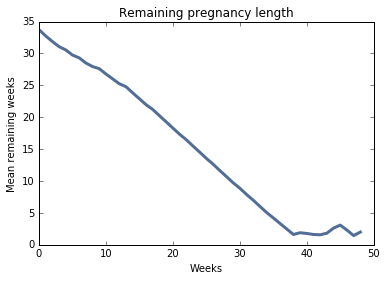

In [25]:
rem_life1 = sf1.RemainingLifetime()
thinkplot.Plot(rem_life1)
thinkplot.Config(title='Remaining pregnancy length',
                 xlabel='Weeks',
                 ylabel='Mean remaining weeks')

And here's the median remaining time until first marriage as a function of age.

In [26]:
hf, sf2 = EstimateMarriageSurvival(resp6)

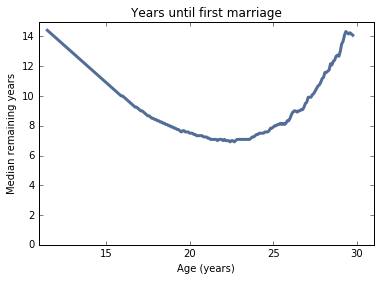

In [27]:
func = lambda pmf: pmf.Percentile(50)
rem_life2 = sf2.RemainingLifetime(filler=np.inf, func=func)
    
thinkplot.Plot(rem_life2)
thinkplot.Config(title='Years until first marriage',
                 ylim=[0, 15],
                 xlim=[11, 31],
                 xlabel='Age (years)',
                 ylabel='Median remaining years')

## Exercises

**Exercise:**    In NSFG Cycles 6 and 7, the variable `cmdivorcx` contains the date of divorce for the respondent’s first marriage, if applicable, encoded in century-months.

Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing. Estimate the hazard and survival curve for the duration of marriage.

Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.

Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.

In [28]:
def CleanData(resp):
    """Cleans respondent data.

    resp: DataFrame
    """
    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

    resp['notdivorced'] = resp.cmdivorcx.isnull().astype(int)
    resp['duration'] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp['durationsofar'] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    month0 = pd.to_datetime('1899-12-15')
    dates = [month0 + pd.DateOffset(months=cm) 
             for cm in resp.cmbirth]
    resp['decade'] = (pd.DatetimeIndex(dates).year - 1900) // 10

In [29]:
CleanData(resp6)
married6 = resp6[resp6.evrmarry==1]

CleanData(resp7)
married7 = resp7[resp7.evrmarry==1]

In [30]:
# Solution goes here

In [31]:
# Solution goes here

In [32]:
# Solution goes here

In [33]:
# Solution goes here

In [34]:
# Solution goes here